# NeRF

Synthesizing novel views of complex scenes by representing those scenes as **Neural Radiance Fields**. In this, a scene is represented using a fully-connected deep neural network and synthesize the novel views of this complex scene by optimizing an underlying continuous volumetric scene function using a sparse set of input views.

![nerf](https://www.delasign.com/CDN/images/Hero_2022-06-06-142922_aeln.webp)

## 1. Data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import time
from tqdm import tqdm

In [ ]:
# Dataset Ref: http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
data = np.load('tiny_nerf_data.npz')
data

NpzFile 'tiny_nerf_data.npz' with keys: images, poses, focal

In [3]:
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
H = H // 2
W = W // 2

In [4]:
def transform(img, H, W):
    img = img * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img = img.resize((H, W))
    img = np.array(img) 
    img = img / 255
    img = img.astype(np.float32)

    return img


In [5]:
resized_images = []
for i, img in enumerate(images):
    resized_images.append(transform(img, H, W))

In [6]:
images = np.array(resized_images)

In [7]:
print(f"Images shape: {images.shape}, Poses shape: {poses.shape}, Focal: {focal}")

Images shape: (106, 50, 50, 3), Poses shape: (106, 4, 4), Focal: 138.88887889922103


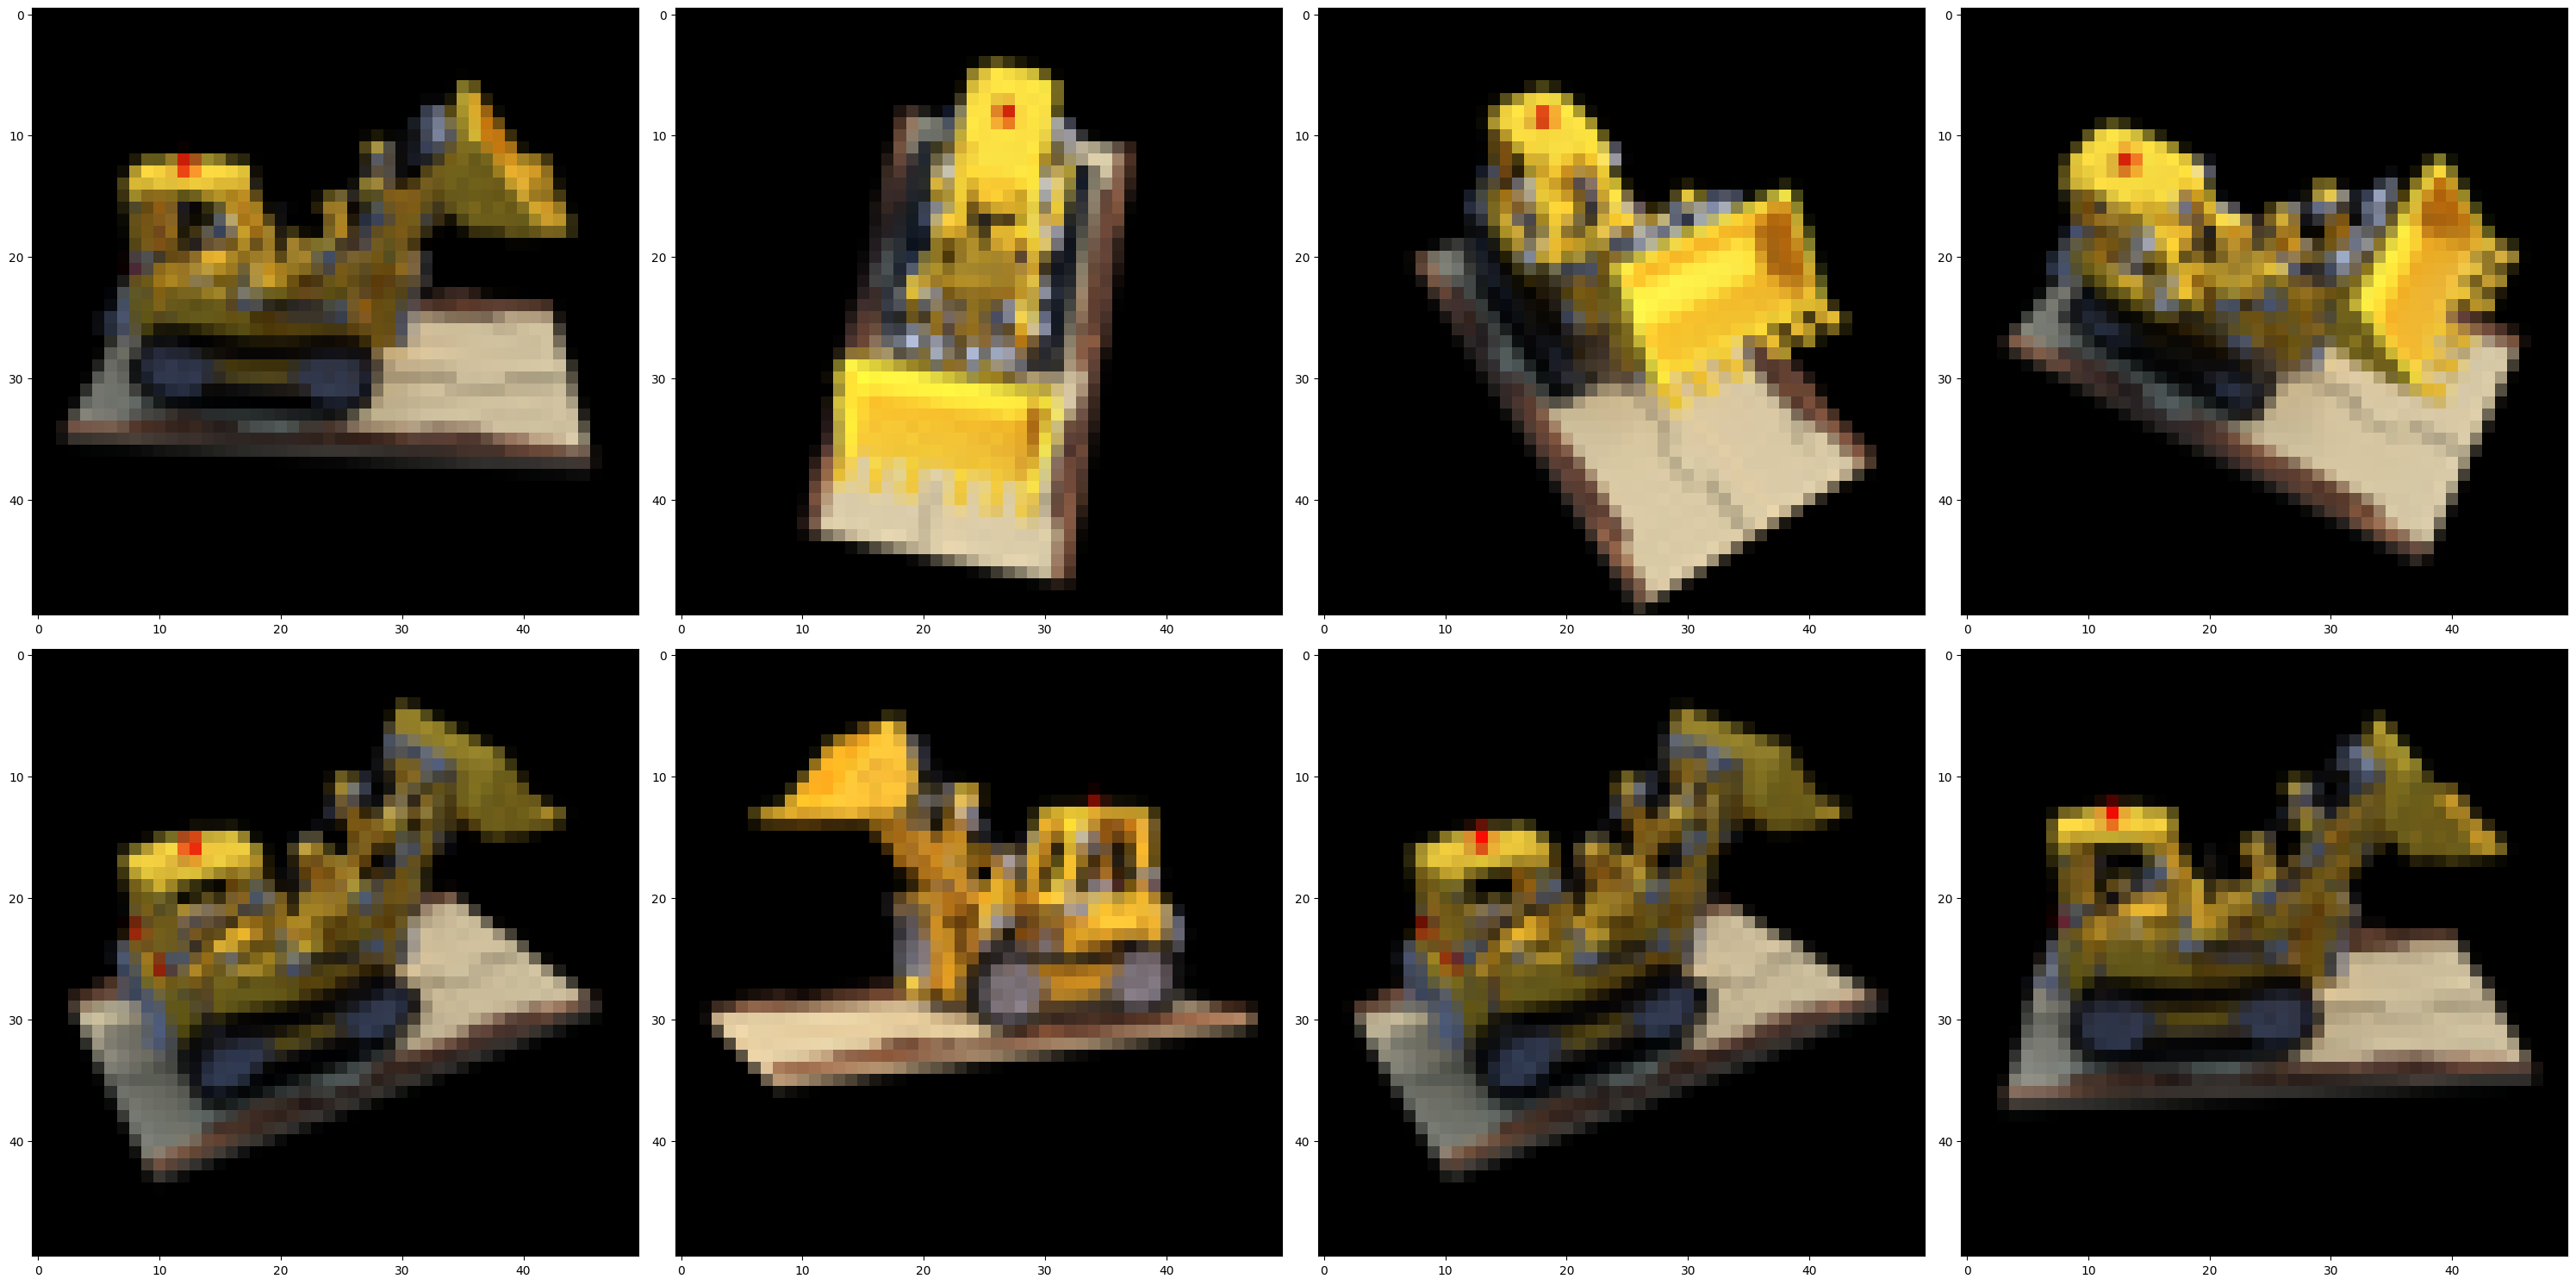

In [8]:
rows, cols = 2, 4
fig, axs = plt.subplots(rows, cols, figsize=(30, 30))
a = 90
for i in range(0, rows):
    for j in range(0, cols):
        axs[i, j].imshow(images[a])
        a += 1

plt.subplots_adjust(wspace = 0.005, hspace = -0.9)
fig.tight_layout()
plt.show()

Train images shape: (100, 50, 50, 3), Test image shape: (50, 50, 3)
Test image


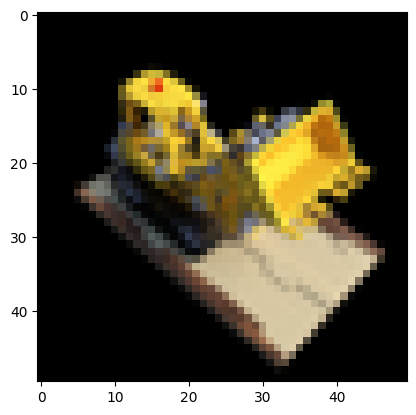

In [9]:
train_images = images[:100]
train_poses = poses[:100]
test_image = images[101]
test_pose = poses[101]
print(f"Train images shape: {train_images.shape}, Test image shape: {test_image.shape}")
print("Test image")
plt.imshow(test_image)
plt.show()

In [10]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(torch.cuda.get_device_properties(i))
        return torch.device('cuda')
    else:
        return torch.device('cpu')

## 2. Model

![nerf-architecture](https://viso.ai/wp-content/uploads/2024/04/neural-radiance-fields-architecture-1060x433.jpg)

Input vectors are shown in green, intermediate hidden layers are shown in blue, output vectors
are shown in red, and the number inside each block signifies the vector’s dimension. 
All layers are standard fully-connected layers, black arrows indicate layers with ReLU activations, orange arrows indicate layers with no activation, dashed black arrows indicate layers with sigmoid activation, and $+$ denotes vector
concatenation. The positional encoding of the input location $(γ(x))$ is passed through 8 fully-connected ReLU layers, each with 256 channels. It includes a skip connection that concatenates this input to the fifth layer’s activation. An additional layer outputs the volume density $σ$ (which is rectified using a ReLU to ensure that the output volume density is nonnegative) and a 256-dimensional feature vector. This feature vector is concatenated with the positional encoding of the input viewing direction $(γ(d))$, and is processed by an additional fully-connected ReLU layer with 128 channels. A final layer (with a sigmoid activation) outputs the emitted RGB radiance at position $x$, as viewed by a ray with direction $d$.

**Optimizing a Neural Radiance Field**
1. Positional Encoding:

    It is founded that having the network $FΘ$ directly operate on $xyzθφ$ input coordinates results in renderings that perform poorly at representing high-frequency variation in color and geometry. In order to control this poor effect, positional encoding involves in mapping the inputs to the higher dimensional space using high frequency functions before passing them to the network enables better fitting of data that contains high frequency variation.
    $$\gamma(p) = (\sin(2^0\pi p), \cos(2^0\pi p), \dots, \sin(2^{L-1}\pi p), \cos(2^{L-1}\pi p))$$

2. Hierarchical Volume Sampling:

    This method propose a hierarchical representation that increases rendering efficiency by allocating samples proportionally to their expected effect on the final rendering. Instead of just using a single network to represent the scene, we simultaneously optimize two networks: one **coarse** and one **fine**. We first sample a set of $N_{c}$ locations using stratified sampling, and evaluate the **coarse** network. Given the output of this **coarse** network, we then produce a more informed sampling of points along each ray where samples are biased towards the relevant parts of the volume.

In [ ]:
class Nerf(nn.Module):

    def __init__(self, pos_enc_dim: int = 63, view_enc_dim: int = 27, hidden_dim: int = 256) -> None:
        """
        Nerf model architecture.

        Args:
            pos_enc_dim: Dimension of encoded position values.
            view_enc_dim: Dimension of encoded view direction values.
            hidden_dim: Hidden dimension of MLP.
        """
        super(Nerf, self).__init__()

        self.first_layer = nn.Sequential(nn.Linear(pos_enc_dim, hidden_dim),
                                         nn.ReLU()
                                        )
        
        self.pre_skip_layers = nn.Sequential()
        for _ in range(0, 3):
            self.pre_skip_layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.pre_skip_layers.append(nn.ReLU())

        self.skip_layer = nn.Sequential(nn.Linear(pos_enc_dim + hidden_dim, hidden_dim),
                                        nn.ReLU())
        
        self.post_skip_layers = nn.Sequential()
        for _ in range(0, 3):
            self.post_skip_layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.post_skip_layers.append(nn.ReLU())

        self.density_layer = nn.Sequential(nn.Linear(hidden_dim, 1), 
                                           nn.ReLU())
        self.feature_layer = nn.Linear(hidden_dim, hidden_dim)

        self.color_layer_1 = nn.Sequential(nn.Linear(view_enc_dim + hidden_dim, hidden_dim // 2),
                                           nn.ReLU())
        self.color_layer_2 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid())
    
    @staticmethod
    def encoding(x: torch.Tensor, L: int) -> torch.Tensor:
        enc = [x]
        for i in range(L):
            enc.append(torch.sin((2 ** i) * x))
            enc.append(torch.cos((2 ** i) * x))
        
        return torch.concat(enc, dim = -1)
    
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:

        pos = x[..., :3] # Position values
        view_d = x[..., 3:] # View direction values

        # Positional Encoding
        pos_enc = self.encoding(pos, 10) 
        view_d_enc = self.encoding(view_d, 4)

        out = self.first_layer(pos_enc) # First layer
        out = self.pre_skip_layers(out) # Pre-skip layers

        out = torch.concat([pos_enc, out], dim = -1) 
        out = self.skip_layer(out) # Skip-connection layer

        out = self.post_skip_layers(out) # Post-skip layers

        sigma = self.density_layer(out) # Computation of density

        out = self.feature_layer(out) # Extraction of hidden feature vectors

        out = torch.concat([view_d_enc, out], dim = -1) 
        out = self.color_layer_1(out)

        out = self.color_layer_2(out) # Extraction of RGB radiance

        return torch.cat([sigma, out], dim=-1)


In [ ]:
def get_rays(H: int, W: int, focal: float, c2w: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
  """
  Generate rays for a given camera configuration.

  Args:
    H: Image height.
    W: Image width.
    focal: Focal length.
    c2w: Camera-to-world transformation matrix (4x4).

  Returns:
    rays_o: Ray origins (H*W, 3).
    rays_d: Ray directions (H*W, 3).
  """
  device = c2w.device  # Get the device of c2w
  focal = torch.from_numpy(focal).to(device)

  i, j = torch.meshgrid(
      torch.arange(W, dtype = torch.float32, device = device),
      torch.arange(H, dtype = torch.float32, device = device),
      indexing = 'xy'
  )
  dirs = torch.stack(
      [(i - W * .5) / focal, -(j - H * .5) / focal, -torch.ones_like(i, device = device)], -1
  )

  rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)
  rays_d = rays_d.view(-1, 3)
  rays_o = c2w[:3, -1].expand(rays_d.shape)

  return rays_o, rays_d

In [13]:
def sample_pdf(bins: torch.Tensor, weights: torch.Tensor, N_samples: int, det: bool = False) -> torch.Tensor:
    # Add a tiny value to prevent division by zero
    weights =  weights + 1e-5
    pdf = weights / torch.sum(weights, -1, keepdim = True)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[..., :1]), cdf], -1)

    if det:
        u = torch.linspace(0, 1, steps = N_samples, device = weights.device)
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples], device = weights.device)

    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, right = True)
    below = torch.clamp(inds - 1, min=0)
    above = torch.clamp(inds, max = cdf.shape[-1] - 1)

    inds_sampled = torch.stack([below, above], -1)
    cdf_gathered = torch.gather(cdf.unsqueeze(-2).expand(*inds_sampled.shape[:-1], cdf.shape[-1]), -1, inds_sampled)
    bins_gathered = torch.gather(bins.unsqueeze(-2).expand(*inds_sampled.shape[:-1], bins.shape[-1]), -1, inds_sampled)

    denom = cdf_gathered[..., 1] - cdf_gathered[..., 0]
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_gathered[..., 0]) / denom
    samples = bins_gathered[..., 0] + t * (bins_gathered[..., 1] - bins_gathered[..., 0])
    return samples


## 3. Volume Rendering

In [ ]:
def render_rays(coarse_network: Nerf, 
                rays_o: torch.Tensor, 
                rays_d: torch.Tensor, 
                near: float, 
                far: float, 
                N_samples: int, 
                fine_network: Nerf, 
                N_importance: int, 
                device: str, 
                rand: bool = False, 
                chunk: int = 128) -> tuple:
    
    def batchify(fn, chunk):
        return lambda inputs: torch.cat([fn(inputs[i : i + chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Sampling
    z_vals = torch.linspace(near, far, steps = N_samples, device = device)

    if rand:
        z_vals += torch.rand(*z_vals.shape[:-1], N_samples, device = rays_o.device) * (far - near) / N_samples

    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    # Normalize view directions
    view_dirs = rays_d / torch.norm(rays_d, dim = -1, keepdim = True)
    view_dirs = view_dirs[..., None, :].expand(pts.shape)

    input_pts = torch.cat((pts, view_dirs), dim = -1)
    raw = batchify(coarse_network, chunk)(input_pts)

    sigma_a = raw[..., 0]  # Shape: [batch, N_samples]
    rgb = raw[..., 1:]    # Shape: [batch, N_samples, 3]

    # Improved volume rendering
    dists = z_vals[..., 1:] - z_vals[..., :-1]  # Shape: [batch, N_samples-1]
    dists = torch.cat([dists, torch.tensor([1e10], device = device).expand(dists[..., :1].shape)], -1)

    # No need to manually expand dists as broadcasting will handle it
    alpha = 1. - torch.exp(-sigma_a * dists)  # Shape: [batch, N_samples]

    # Computing transmittance
    ones_shape = (alpha.shape[0], 1)
    T = torch.cumprod(
        torch.cat([
            torch.ones(ones_shape, device = device),
            1. - alpha + 1e-10
        ], dim = 1),
        dim = 1
    )[:, :-1]  # Shape: [batch, N_samples]

    weights = alpha * T  # Shape: [batch, N_samples]

    # Compute final colors and depths
    rgb_map_coarse = torch.sum(weights[...,None] * rgb, dim = -2)  # Sum along sample dimension
    depth_map_coarse = torch.sum(weights.squeeze(-1) * z_vals, dim = -1)  # Shape: [batch]
    acc_map_coarse = torch.sum(weights.squeeze(-1), dim = -1)  # Shape: [batch]


    # Hierarchical sampling
    z_vals_mid = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
    z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], N_importance, det = not rand)
    # z_samples = z_samples.detach()
    z_vals = torch.broadcast_to(z_vals, list(rays_o.shape[:-1]) + [N_samples]).clone()
    z_vals_combined, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1)

    pts_fine = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]
    view_dirs_fine = view_dirs[..., :1, :].expand(pts_fine.shape)

    input_pts_fine = torch.cat((pts_fine, view_dirs_fine), dim = -1)
    raw_fine = batchify(fine_network, chunk)(input_pts_fine)

    sigma_fine = raw_fine[..., 0]
    rgb_fine = raw_fine[..., 1:]

    dists_fine = z_vals_combined[..., 1:] - z_vals_combined[..., :-1]  # Shape: [batch, N_samples-1]
    dists_fine = torch.cat([dists_fine, torch.tensor([1e10], device = device).expand(dists_fine[..., :1].shape)], -1)

    alpha_fine = 1. - torch.exp(-sigma_fine * dists_fine)  # Shape: [batch, N_samples]

    # Computing transmittance
    ones_shape = (alpha_fine.shape[0], 1)
    T = torch.cumprod(
        torch.cat([
            torch.ones(ones_shape, device = device),
            1. - alpha_fine + 1e-10
        ], dim = 1),
        dim = 1
    )[:, :-1]  # Shape: [batch, N_samples]

    weights_fine = alpha_fine * T  # Shape: [batch, N_samples]

    rgb_map_fine = torch.sum(weights_fine[...,None] * rgb_fine, dim = -2)  # Sum along sample dimension
    depth_map_fine = torch.sum(weights_fine.squeeze(-1) * z_vals_combined, dim = -1)  # Shape: [batch]
    acc_map_fine = torch.sum(weights_fine.squeeze(-1), dim = -1)  # Shape: [batch]

    return rgb_map_coarse, depth_map_coarse, acc_map_coarse, rgb_map_fine, depth_map_fine, acc_map_fine

## 4. Training and Evaluation

In [ ]:
def train(images: np.ndarray, 
          poses: np.ndarray, 
          H: int, 
          W: int,
          focal: float,
          testpose: np.ndarray,
          testimg: np.ndarray,
          lr: float,
          N_iter: int,
          N_samples: int,
          N_importance: int,
          device: str) -> tuple:

    # Initialize models and optimizer
    coarse_model = Nerf().to(device)
    fine_model = Nerf(hidden_dim = 128).to(device)

    criterion = nn.MSELoss(reduction = 'mean')
    optimizer = torch.optim.AdamW(list(coarse_model.parameters()) + list(fine_model.parameters()), lr = lr)

    i_plot = 50
    psnrs = []
    iternums = []
    t = time.time()

    # Convert data to tensors
    images_tensor = torch.from_numpy(images).float()
    poses_tensor = torch.from_numpy(poses).float()

    for i in range(N_iter + 1):

        img_i = np.random.randint(images.shape[0])

        target = images_tensor[img_i].to(device)  # Use the corresponding image
        pose = poses_tensor[img_i].to(device)     # Use the corresponding pose

        rays_o, rays_d = get_rays(H, W, focal, pose)

        optimizer.zero_grad()

        coarse_model.train()
        fine_model.train()
        rgb_coarse, depth_coarse, acc_coarse, rgb_fine, depth_fine, acc_fine = render_rays(coarse_model, rays_o, rays_d, near = 2.,
                                                                                           far = 6., N_samples = N_samples, fine_network = fine_model,
                                                                                           N_importance = N_importance, device = device, rand = True)

        rgb_coarse = rgb_coarse.reshape(H, W, 3)
        rgb_fine = rgb_fine.reshape(H, W, 3)

        loss = criterion(rgb_coarse, target) + criterion(rgb_fine, target)

        loss.backward()
        optimizer.step()

        if i % i_plot == 0:
            print(f'Iteration: {i}, Loss: {loss.item():.6f}, Time: {(time.time() - t) / i_plot:.2f} secs per iter')
            t = time.time()

            with torch.no_grad():
                coarse_model.eval()
                fine_model.eval()
                test_img = torch.from_numpy(testimg).float().to(device)
                test_pse = torch.from_numpy(testpose).float().to(device)
                rays_o, rays_d = get_rays(H, W, focal, test_pse)
                rgb_coarse, depth_coarse, acc_coarse, rgb_fine, depth_fine, acc_fine = render_rays(coarse_model, rays_o, rays_d, near = 2.,
                                                                                           far = 6., N_samples = N_samples, fine_network = fine_model,
                                                                                           N_importance = N_importance, device = device)
                rgb_coarse = rgb_coarse.reshape(H, W, 3)
                rgb_fine = rgb_fine.reshape(H, W, 3)
                loss = criterion(rgb_coarse, test_img) + criterion(rgb_fine, test_img)
                psnr = -10. * torch.log10(loss)

                psnrs.append(psnr.item())
                iternums.append(i)

                plt.figure(figsize=(10,4))
                plt.subplot(121)
                plt.imshow(rgb_fine.cpu().detach().numpy())
                plt.title(f'Iteration: {i}')
                plt.subplot(122)
                plt.plot(iternums, psnrs)
                plt.title('PSNR')
                plt.show()
                del test_img, test_pse

    return coarse_model, fine_model

In [16]:
device = get_default_device()
print("Device: ", device)
max_iter = 1000
N_samples = 64
N_importance = 128
lr = 5e-4

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30, uuid=eafe3e1a-82bb-fec8-2948-094f6277e5f8, L2_cache_size=3MB)
Device:  cuda


Iteration: 0, Loss: 0.328319, Time: 0.01 secs per iter


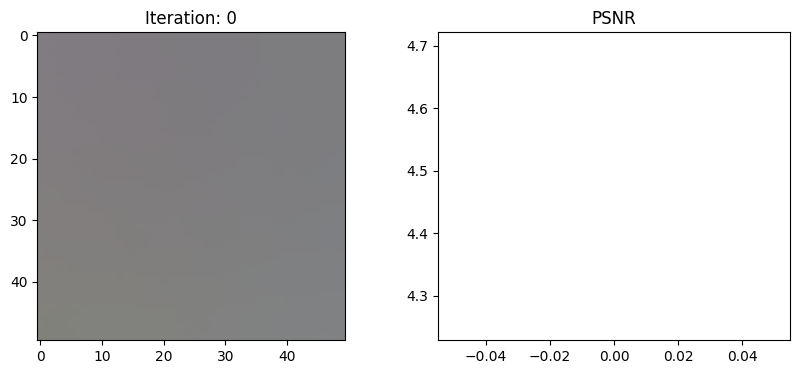

Iteration: 50, Loss: 0.108990, Time: 0.72 secs per iter


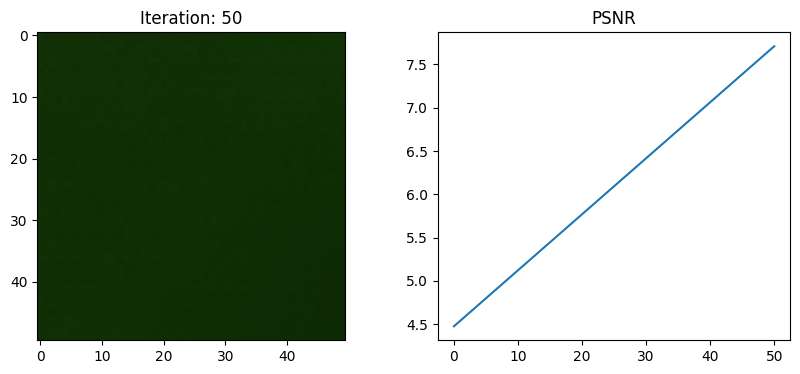

Iteration: 100, Loss: 0.106935, Time: 0.74 secs per iter


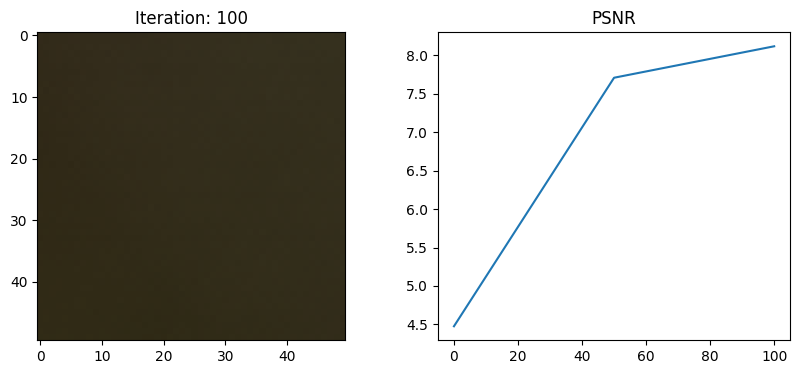

Iteration: 150, Loss: 0.157558, Time: 0.85 secs per iter


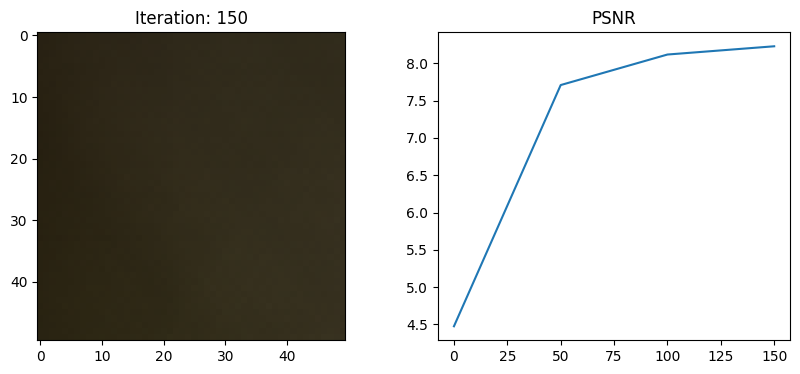

Iteration: 200, Loss: 0.108158, Time: 0.73 secs per iter


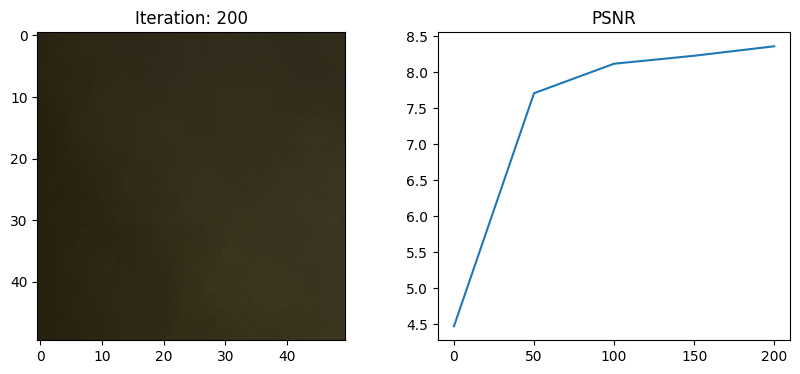

Iteration: 250, Loss: 0.133403, Time: 0.75 secs per iter


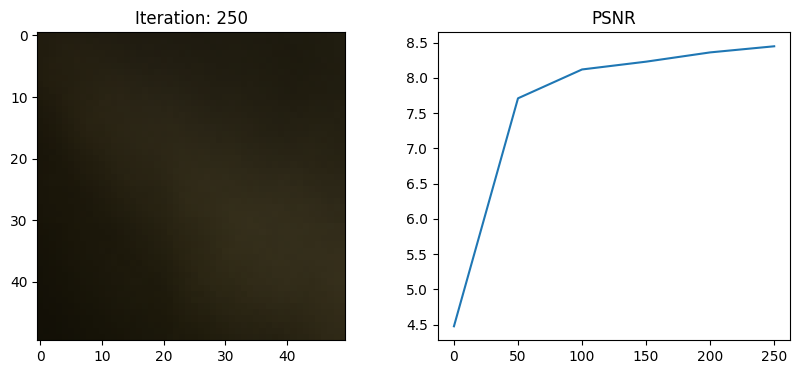

Iteration: 300, Loss: 0.060374, Time: 0.77 secs per iter


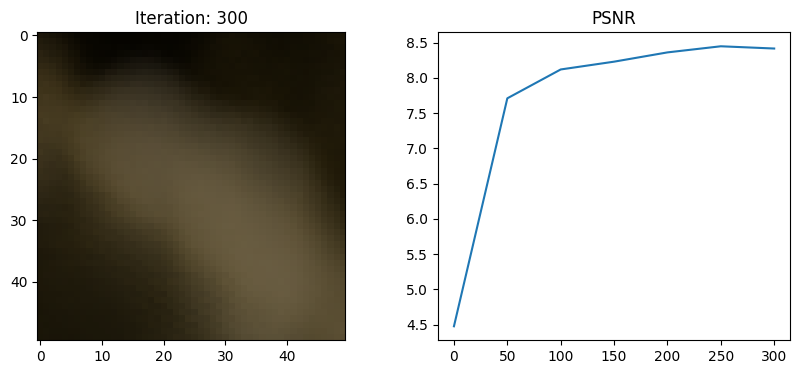

Iteration: 350, Loss: 0.070918, Time: 0.75 secs per iter


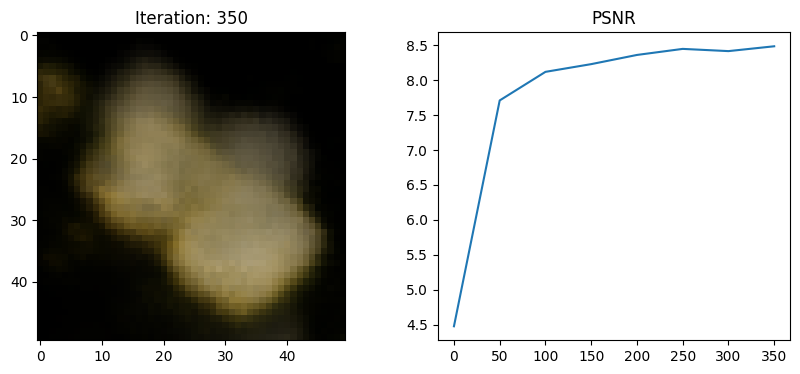

Iteration: 400, Loss: 0.173956, Time: 0.73 secs per iter


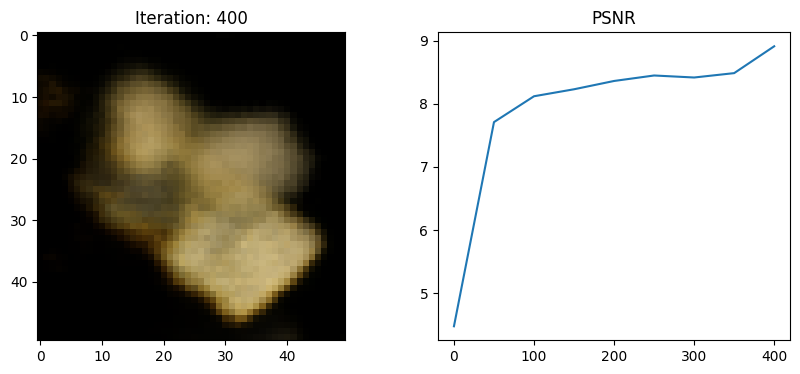

Iteration: 450, Loss: 0.160192, Time: 0.71 secs per iter


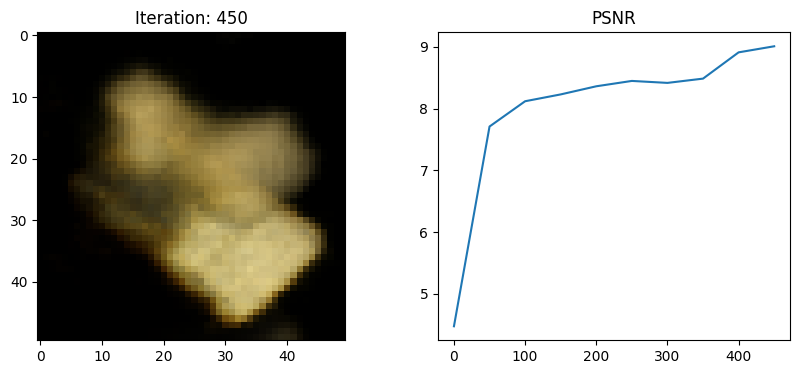

Iteration: 500, Loss: 0.157414, Time: 0.71 secs per iter


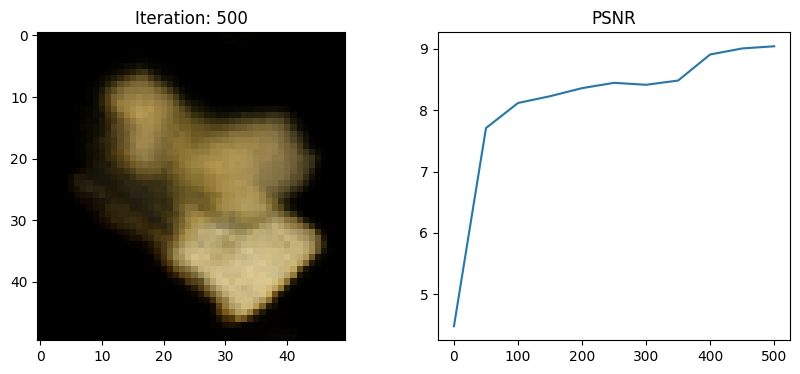

Iteration: 550, Loss: 0.047213, Time: 0.71 secs per iter


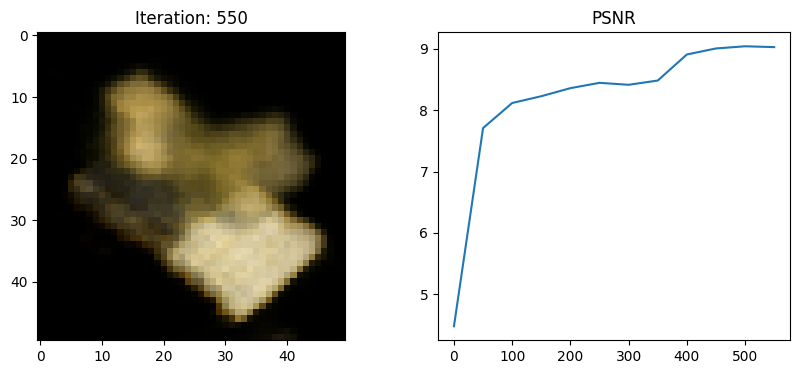

Iteration: 600, Loss: 0.118954, Time: 0.71 secs per iter


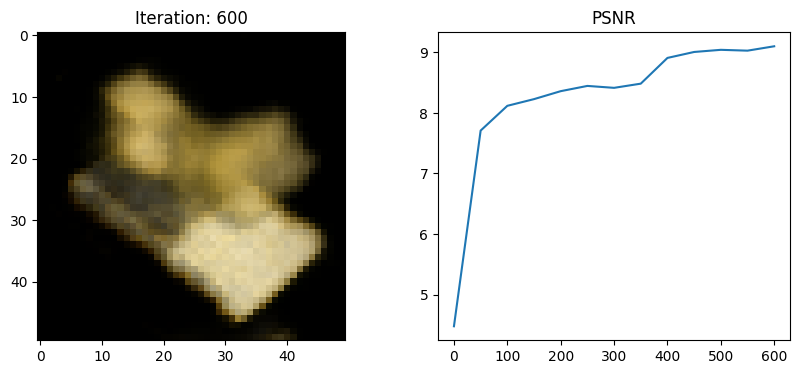

Iteration: 650, Loss: 0.155241, Time: 0.71 secs per iter


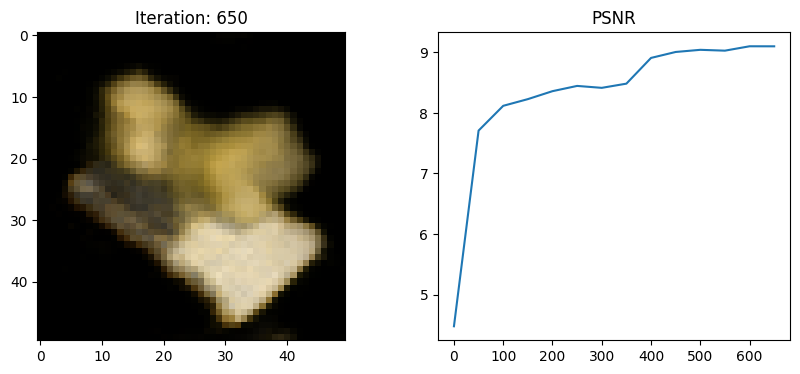

Iteration: 700, Loss: 0.093937, Time: 0.71 secs per iter


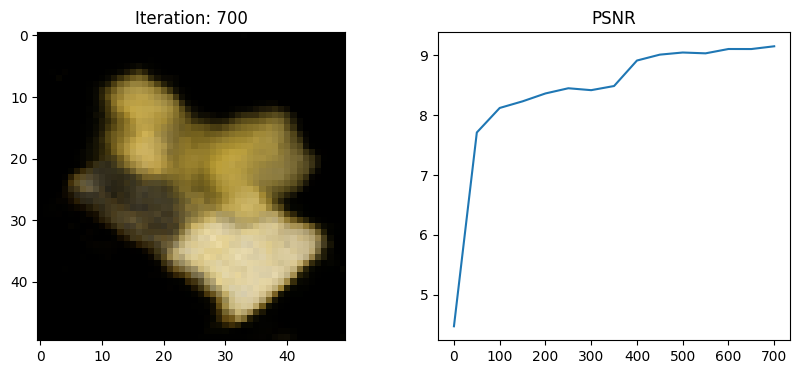

Iteration: 750, Loss: 0.074380, Time: 0.71 secs per iter


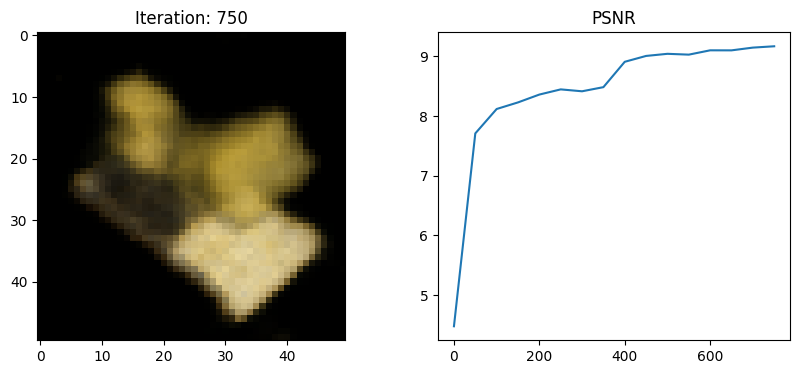

Iteration: 800, Loss: 0.148539, Time: 0.71 secs per iter


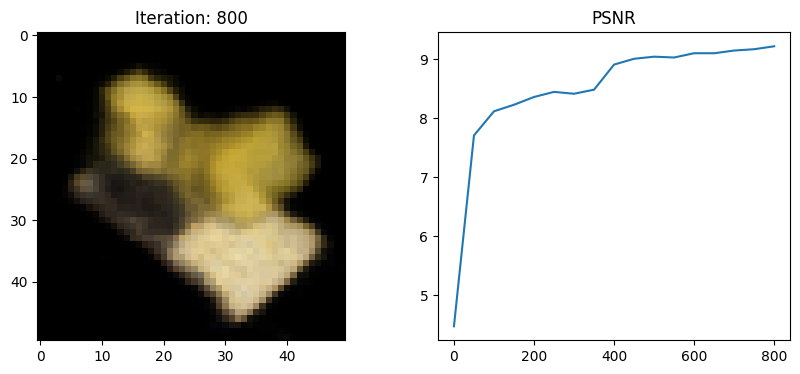

Iteration: 850, Loss: 0.034593, Time: 0.72 secs per iter


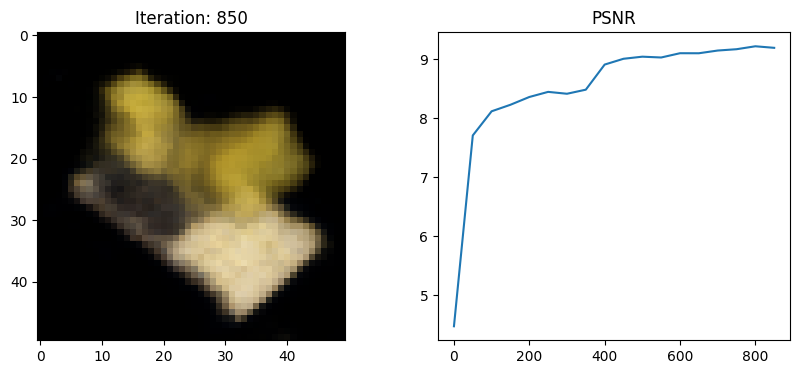

Iteration: 900, Loss: 0.160267, Time: 0.71 secs per iter


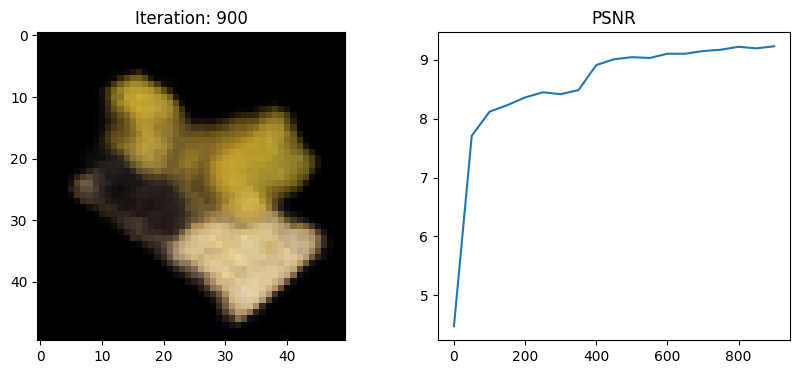

Iteration: 950, Loss: 0.083256, Time: 0.71 secs per iter


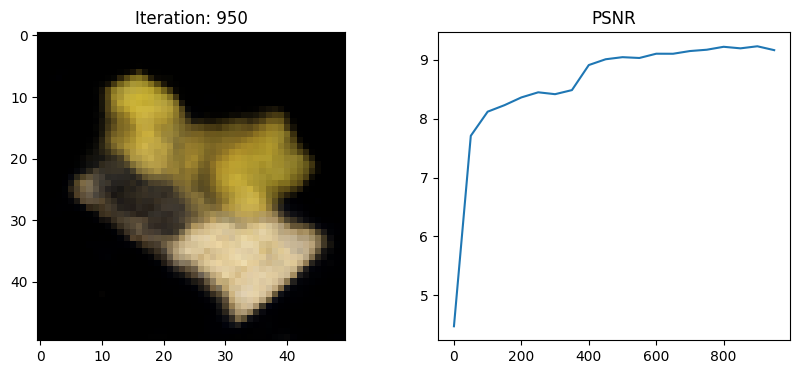

In [17]:
coarse_model, fine_model = train(train_images, train_poses, H, W, focal, test_pose, test_image, lr, max_iter, N_samples,
                                 N_importance, device)

In [19]:
torch.save(coarse_model.state_dict(), 'coarse_model.pth')
torch.save(fine_model.state_dict(), 'fine_model.pth')

## 5. Rendering new views

In [15]:
device = get_default_device()
print('Device: ', device)
coarse_model = Nerf()
coarse_model.load_state_dict(torch.load('coarse_model.pth', weights_only = True, map_location = 'cpu'), strict = True)
fine_model = Nerf(hidden_dim = 128)
fine_model.load_state_dict(torch.load('fine_model.pth', weights_only = True, map_location = 'cpu'), strict = True)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30, uuid=eafe3e1a-82bb-fec8-2948-094f6277e5f8, L2_cache_size=3MB)
Device:  cuda


<All keys matched successfully>

In [16]:
coarse_model.to(device)
fine_model.to(device)

Nerf(
  (first_layer): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
  )
  (pre_skip_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (skip_layer): Sequential(
    (0): Linear(in_features=191, out_features=128, bias=True)
    (1): ReLU()
  )
  (post_skip_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (density_layer): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): ReLU()
  )
  (feature_layer): Linear(in_features=128, out_features=128, bias=True)
  (color_layer_1): Sequential(
    (0): Linear(i

In [17]:
from ipywidgets import interactive, widgets
N_samples = 64
N_importance = 128

# Transformation matrices in PyTorch
trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1]
], dtype=torch.float32)

rot_phi = lambda phi: torch.tensor([
    [1, 0, 0, 0],
    [0, torch.cos(phi), -torch.sin(phi), 0],
    [0, torch.sin(phi), torch.cos(phi), 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

rot_theta = lambda th: torch.tensor([
    [torch.cos(th), 0, -torch.sin(th), 0],
    [0, 1, 0, 0],
    [torch.sin(th), 0, torch.cos(th), 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

# Pose function with spherical coordinates
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = torch.matmul(rot_phi(torch.Tensor([phi / 180. * np.pi])), c2w)
    c2w = torch.matmul(rot_theta(torch.Tensor([theta / 180. * np.pi])), c2w)
    c2w = torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32) @ c2w
    return c2w

# Function for rendering based on user input
def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])  # Get rays (this is a placeholder)
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
      _, _, _, rgb_fine, depth_fine, acc_fine = render_rays(coarse_model, rays_o, rays_d, near = 2.,
                                                            far = 6., N_samples = N_samples, fine_network = fine_model,
                                                            N_importance = N_importance, device = device)  # Render rays
    rgb = rgb_fine.reshape(H, W, 3).cpu().detach()
    img = torch.clamp(rgb, 0, 1).numpy()  # Clamp RGB values between 0 and 1 and convert to numpy

    plt.figure(2, figsize=(20, 6))
    plt.imshow(img)
    plt.show()

# Interactive slider setup for theta, phi, and radius
sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0]: sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [22]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint = False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
      _, _, _, rgb_fine, depth_fine, acc_fine = render_rays(coarse_model, rays_o, rays_d, near = 2.,
                                                            far = 6., N_samples = N_samples, fine_network = fine_model,
                                                            N_importance = N_importance, device = device)
    rgb = rgb_fine.reshape(H, W, 3)
    frames.append((255 * np.clip(rgb.cpu().detach().numpy(), 0, 1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps = 30, quality = 10)

100%|██████████| 120/120 [00:15<00:00,  7.81it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (50, 50) to (64, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [23]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## 6. References:
1. [Paper](https://arxiv.org/abs/2003.08934)
2. [Official NeRF Blog](https://www.matthewtancik.com/nerf)
3. [GitHub](https://github.com/bharathsivaram10/test-books/blob/main/NeRF.ipynb), [GitHub](https://github.com/dataflowr/notebooks/tree/master/nerf).